<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_07_Metaparameters_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries
## DL Modeling
import time
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## Numerical Analysis
import numpy as np
import scipy.stats as stats

## Dataset Management
import pandas as pd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## High-Quality Figures
from IPython import display
display.set_matplotlib_formats("svg")

# Importance of Data Normalization

## The Iris Dataset (Once Again)

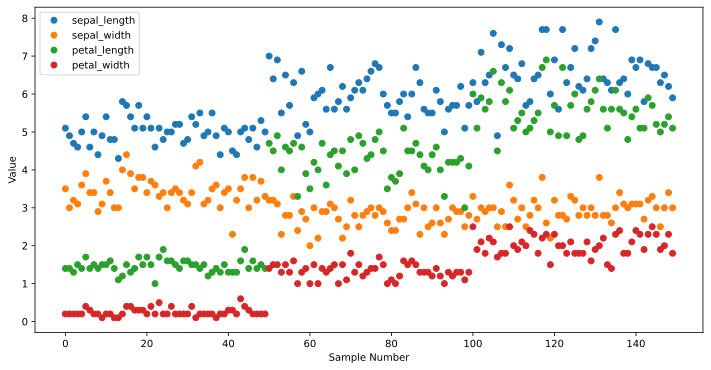

In [2]:
# Import and convert iris dataset
import seaborn as sns
iris = sns.load_dataset("iris")

# Visualize data range
iris.plot(marker="o", linestyle="none", figsize=(12,6))
plt.xlabel("Sample Number")
plt.ylabel("Value")
plt.show()
# The ranges of data is quite close

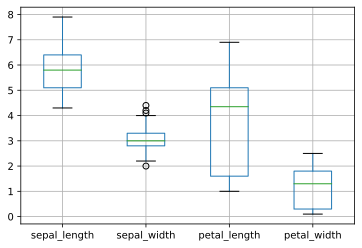

In [3]:
# Use boxplot to confirm
boxplot = iris.boxplot()

In [4]:
# Normalize the features
import scipy.stats as stats
cols2zscore = iris.keys()
cols2zscore = cols2zscore.drop("species")
iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

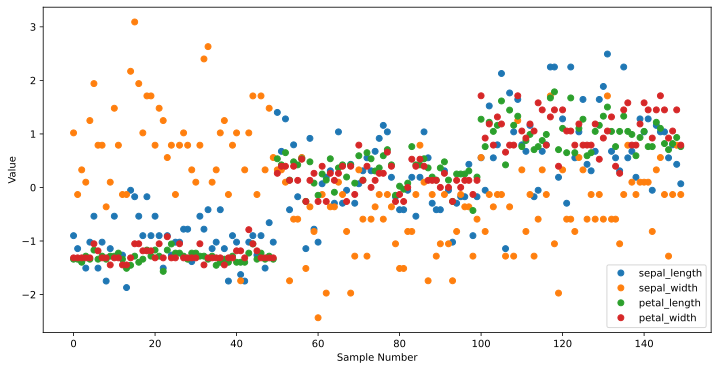

In [5]:
# Visualize data range
iris.plot(marker="o", linestyle="none", figsize=(12,6))
plt.xlabel("Sample Number")
plt.ylabel("Value")
plt.show()
# Since the original data did not have that much variation, normalization does not have such big impact

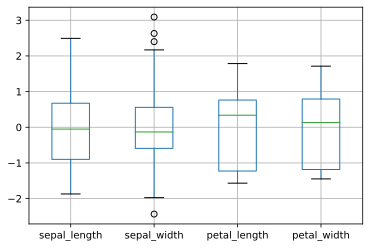

In [6]:
# Check once again in a boxplot
boxplot = iris.boxplot()

## Wine Quality Dataset (No Normalization)

In [7]:
# Organize the data
# Download the data from original database
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")
# Remove the two outliers
data = data[data["total sulfur dioxide"] < 200]

# No normalization this time
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")

# Ceate the new boolean for quality
data["boolQuality"] = 0
data["boolQuality"][data["quality"] > 5] = 1

<ipython-input-7-68b5ac299513>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["boolQuality"][data["quality"] > 5] = 1


In [8]:
# Convert the data into tensors
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data["boolQuality"].values).float()

print(dataT.shape)
print(labels.shape)

# We need the labels to be tensor
labels = labels[:,None]
print(labels.shape)

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


In [9]:
# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = 0.1)

# Convert to Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [10]:
# Define the model class
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer
        self.input = nn.Linear(11,16)

        # Define two hidden layers
        self.fc1 = nn.Linear(16,32) # fc = fully connected
        self.fc2 = nn.Linear(32,32)

        # Define the output layer
        self.output = nn.Linear(32,1)

    # Forwad Pass
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

In [11]:
numepochs = 1000

def trainTheModel():

    # Loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr = 0.01)

    # Initialize the losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # switch on he training mode
        winenet.train()

        # Loop over the training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from single batch
            batchLoss.append(loss.item())

            # Training Accuracy for single batch
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        # End of the batch loop

        # Average training accuracy for batches in this epoch
        trainAcc.append(np.mean(batchAcc))

        # Average losses accross the baches
        losses[epochi] = np.mean(batchLoss)

        # test the accuracy
        winenet.eval()

        # Extract X and y from dataloader
        X,y = next(iter(test_loader))
        # deactivate autograd
        with torch.no_grad():
            yHat = winenet(X)

        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
    # Final output
    return trainAcc, testAcc, losses

In [12]:
# Range the batch sizes
batchsizes = 2**np.arange(1,10,2)

# Initialize the output result matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest = np.zeros((numepochs, len(batchsizes)))

# Computational time
comptime = np.zeros(len(batchsizes))

test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# Loop over the batch sizes
for bi in range(len(batchsizes)):
    # Start the timer
    starttime = time.process_time()

    # Create train loadr object for each iteration
    train_loader = DataLoader(train_data, batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

    # Create and train a model
    winenet = ANNwine()
    trainAcc, testAcc, losses = trainTheModel()

    # Store the data
    accuracyResultsTrain[:,bi] = trainAcc
    accuracyResultsTest[:,bi] = testAcc

    # Computation time
    comptime[bi] = time.process_time() - starttime

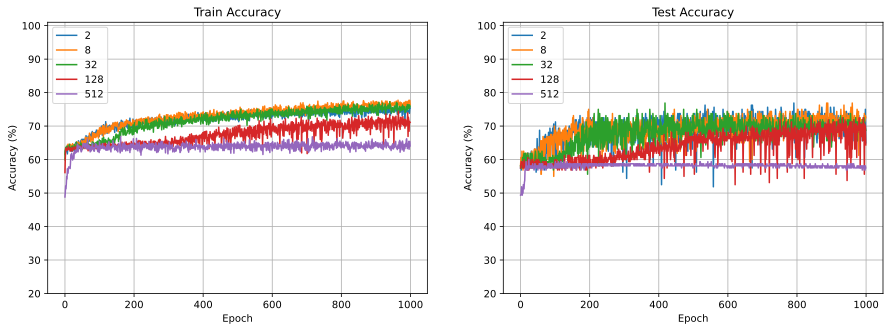

In [13]:
# Plot the results
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title("Train Accuracy")
ax[1].plot(accuracyResultsTest)
ax[1].set_title("Test Accuracy")

# Common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([20,101])
    ax[i].grid()

plt.show()

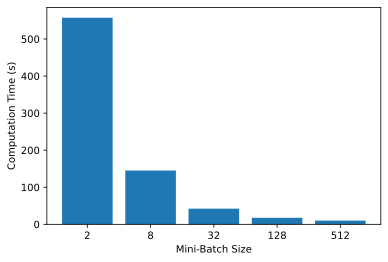

In [14]:
# Bar plot of computation time
plt.bar(range(len(comptime)), comptime, tick_label=batchsizes)
plt.xlabel("Mini-Batch Size")
plt.ylabel("Computation Time (s)")
plt.show()

# Batch Normalization

In [15]:
# Again use the wine data, but normalize the raw data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")

data = data[data["total sulfur dioxide"] < 200]

# No normalization this time
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# Ceate the new boolean for quality
data["boolQuality"] = 0
data["boolQuality"][data["quality"] > 5] = 1

data.head()

<ipython-input-15-158138040c99>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["boolQuality"][data["quality"] > 5] = 1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,1
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0


In [16]:
# Convert the data into tensors
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data["boolQuality"].values).float()

print(dataT.shape)
print(labels.shape)

# We need the labels to be tensor
labels = labels[:,None]
print(labels.shape)

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


In [17]:
# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = 0.1)

# Convert to Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate to dataloader objects
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [18]:
class ANNwine_withBNorm(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer
        self.input = nn.Linear(11,16)

        # Define two hidden layers
        self.fc1 = nn.Linear(16,32) # fc = fully connected
        self.bnorm1 = nn.BatchNorm1d(16) # Number of units into this layer
        self.fc2 = nn.Linear(32,20)
        self.bnorm2 = nn.BatchNorm1d(32) # Number of units into this layer

        # Define the output layer
        self.output = nn.Linear(20,1)

    # Forwad Pass
    def forward(self,x, doBN): # doBN is boolean (chose models with/without batch normalization)

        # Input (x starts off normalized, i.e., we normalized the raw data)
        x = F.relu(self.input(x))

        if doBN:
            # Hidden Layer 1
            x = self.bnorm1(x) # Batch normalization
            x = self.fc1(x)    # Weighted combination
            x = F.relu(x)      # Activation Function

            # Hidden Layer 2
            x = self.bnorm2(x) # Batch Normalization
            x = self.fc2(x)    # Weighted Combination
            x = F.relu(x)      # Activation Funcion

        else:
            # Hidden Layer 1
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

        return self.output(x)

In [19]:
# Time to train
numepochs = 1000

def trainTheModel(doBN=True):

    # Loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr = 0.01)

    # Initialize the losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # switch on he training mode
        winenet.train()

        # Loop over the training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward pass and loss
            yHat = winenet(X,doBN)
            loss = lossfun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from single batch
            batchLoss.append(loss.item())

            # Training Accuracy for single batch
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        # End of the batch loop
        # Average training accuracy for batches in this epoch
        trainAcc.append(np.mean(batchAcc))

        # Average losses accross the baches
        losses[epochi] = np.mean(batchLoss)

        # test the accuracy
        winenet.eval()
        # Extract X and y from dataloader
        X,y = next(iter(test_loader))
        # deactivate autograd
        with torch.no_grad():
            yHat = winenet(X,doBN)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
    # Final output
    return trainAcc, testAcc, losses

In [20]:
# Create and Train a model with no batch normalization
winenet = ANNwine_withBNorm()
trainAccNo, testAccNo, lossesNo = trainTheModel(False)

# Create and train a model with batch normalization
winenet = ANNwine_withBNorm()
trainAccWith, testAccWith, lossesWith = trainTheModel(True)

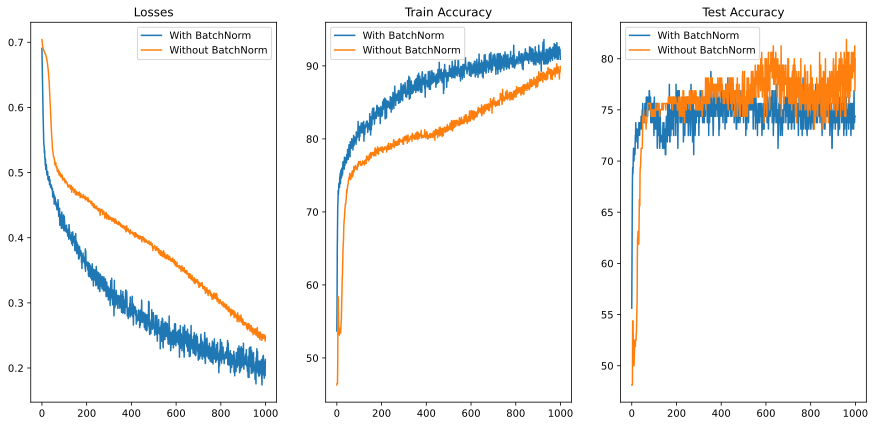

In [21]:
fig,ax = plt.subplots(1,3,figsize=(15,7))

ax[0].plot(lossesWith, label = "With BatchNorm")
ax[0].plot(lossesNo, label = "Without BatchNorm")
ax[0].set_title("Losses")
ax[0].legend()

ax[1].plot(trainAccWith, label = "With BatchNorm")
ax[1].plot(trainAccNo, label = "Without BatchNorm")
ax[1].set_title("Train Accuracy")
ax[1].legend()

ax[2].plot(testAccWith, label = "With BatchNorm")
ax[2].plot(testAccNo, label = "Without BatchNorm")
ax[2].set_title("Test Accuracy")
ax[2].legend()

plt.show()

# Code Challenge: Batch Normalize Synthetic Data

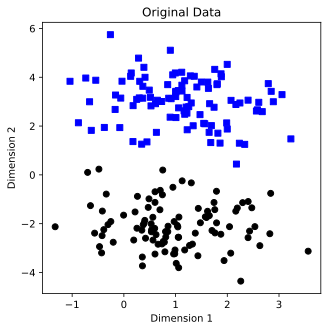

In [22]:
# Create linearly separable data as was done before
nPerClust = 100
blur = 1

# Create the centers
A = [1,3]
B = [1,-2]

# Generate The Data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))
data_np = np.hstack((a,b)).T

# Convert lists into tensors
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# Show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels == 0)[0],0], data[np.where(labels == 0)[0],1], "bs")
plt.plot(data[np.where(labels == 1)[0],0], data[np.where(labels == 1)[0],1], "ko")
plt.title("Original Data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [23]:
# Create the DL model
def createANNmodel(learningRate):

    # Define the model Architecture
    ANNclassify = nn.Sequential(
        nn.Linear(2,16),
        nn.ReLU(),
        nn.BatchNorm1d(16), # Add Batch Normalization
        nn.Linear(16,1),
        nn.ReLU(),
        nn.Linear(1,1),
        nn.Sigmoid(),
        )
    
    # Define the loss function
    lossfun = nn.BCELoss()

    # Define the Sigmoid Function
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)

    return ANNclassify, lossfun, optimizer

In [24]:
# Define a function that trains the model
numepochs = 1000

def trainTheModel(ANNmodel):

    # Initialize the losses
    losses = torch.zeros(numepochs)

    # Loop over the epochs
    for epochi in range(numepochs):

        # Forward Pass
        yHat = ANNmodel(data)

        # Compute the loss
        loss = lossfun(yHat,labels)
        losses[epochi] = loss

        # Back Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Final Forward Step
    predictions = ANNmodel(data)

    # Compute accuracy
    totalAcc = 100*torch.mean(((predictions > 0.5)==labels).float())

    return losses, predictions, totalAcc

In [25]:
# Run it once
ANNclassify, lossfun, optimizer = createANNmodel(0.01)

losses, predictions, totalacc = trainTheModel(ANNclassify)

print("Model Accuracy is {}%".format(totalacc))

Model Accuracy is 100.0%


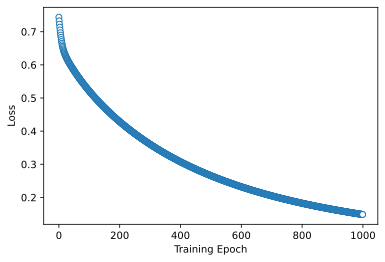

In [26]:
plt.plot(losses.detach(), "o", markerfacecolor="w", linewidth=0.1)
plt.xlabel("Training Epoch")
plt.ylabel("Loss")
plt.show()

In [27]:
# Test for different learning rates
learningrates = np.linspace(0.001, 0.1, 50)

# Initialize accuracry vector for each learning rate
accByLr = []
allLosses = np.zeros((len(learningrates), numepochs))

for i, lr in enumerate(learningrates):

    # Create and run the model
    ANNclassify, lossfun, optimizer = createANNmodel(lr)
    losses, predictions, totalacc = trainTheModel(ANNclassify)

    # Store the results
    accByLr.append(totalacc)
    allLosses[i,:] = losses.detach()

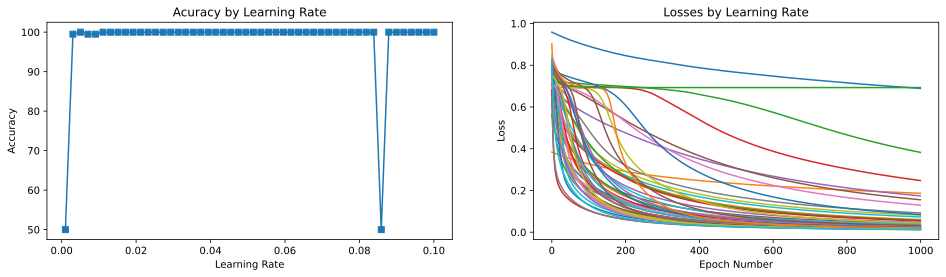

In [28]:
# Plot the whole thing
fig, ax = plt.subplots(1,2, figsize=(16,4))

ax[0].plot(learningrates, accByLr, "s-")
ax[0].set_xlabel("Learning Rate")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Acuracy by Learning Rate")

ax[1].plot(allLosses.T)
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Loss")
ax[1].set_title("Losses by Learning Rate")

plt.show()
# Batch increased the accuracy crazily!

In [29]:
# Average Accuracy above 70%
sum(torch.tensor(accByLr)>70)/len(accByLr)

tensor(0.9600)

# Activation Functions

In [32]:
# In this section we will visualize the effects of activation functions depending on the input
# Create variables to evaluate over
x = torch.linspace(-3, 3, 101)

# Create a function that returns the activated output
def NNoutputx(actfun):
    """
    Get the activation function type
    replace torch.relu() with torch<actfun>
    """
    actfun = getattr(torch, actfun)
    return actfun(x)

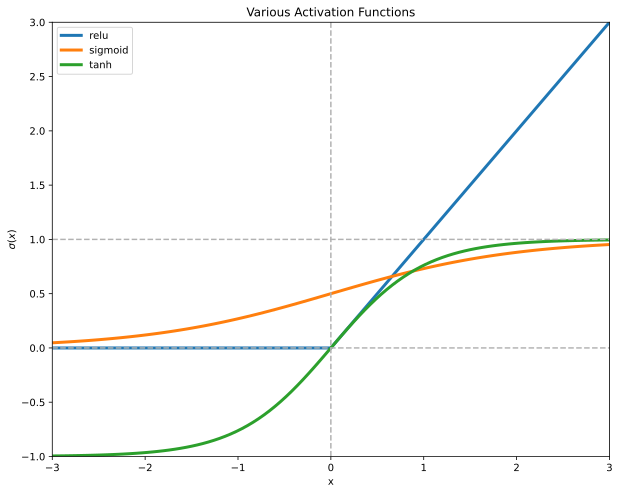

In [33]:
# The list of activation functions we are interested in
activation_functions = ["relu", "sigmoid", "tanh"]

fig = plt.figure(figsize=(10,8))

for actfun in activation_functions:
    plt.plot(x, NNoutputx(actfun), label=actfun, linewidth=3)

# Add reference lines to make it better-looking
dashlinecol = [0.7,0.7,0.7]
plt.plot(x[[0,-1]],[0,0], "--", color=dashlinecol)
plt.plot(x[[0,-1]],[1,1], "--", color=dashlinecol)
plt.plot([0,0], [-1,3], "--", color=dashlinecol)
plt.legend()
plt.xlabel("x")
plt.ylabel("$\sigma(x)$")
plt.title("Various Activation Functions")
plt.xlim(x[[0,-1]])
plt.ylim([-1,3])
plt.show()

In [34]:
# Create a function that returns the activatyed output function this time
def NNoutput(actfun):
    """
    Get the activation function type
    replace torch.nn.relu with torch.nn.<actfun>
    Output is the function itself
    """
    actfun = getattr(torch.nn,actfun)
    return actfun()

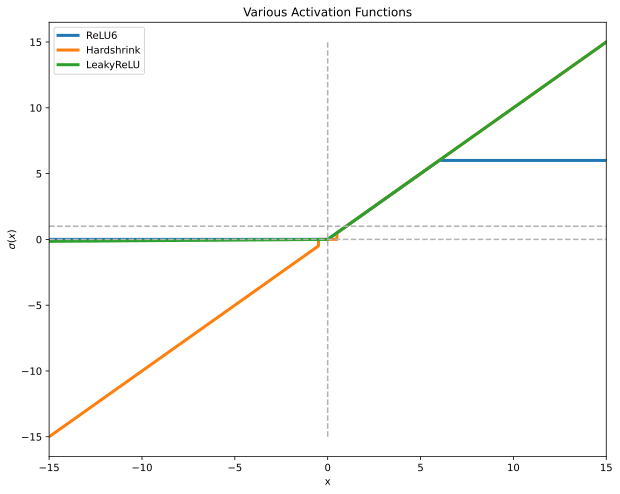

In [37]:
# Try these activation functions now
activation_functions = ["ReLU6", "Hardshrink", "LeakyReLU"]

# ReLU6 saturates at 6, so change te values of x accordingly
x = torch.linspace(-15, 15, 3001)


fig = plt.figure(figsize=(10,8))

for actfun in activation_functions:
    plt.plot(x, NNoutput(actfun)(x), label=actfun, linewidth=3)

# Add reference lines to make it better-looking
dashlinecol = [0.7,0.7,0.7]
plt.plot(x[[0,-1]],[0,0], "--", color=dashlinecol)
plt.plot(x[[0,-1]],[1,1], "--", color=dashlinecol)
plt.plot([0,0], [-15,15], "--", color=dashlinecol)
plt.legend()
plt.xlabel("x")
plt.ylabel("$\sigma(x)$")
plt.title("Various Activation Functions")
plt.xlim(x[[0,-1]])
#plt.ylim([-1,3])
plt.show()

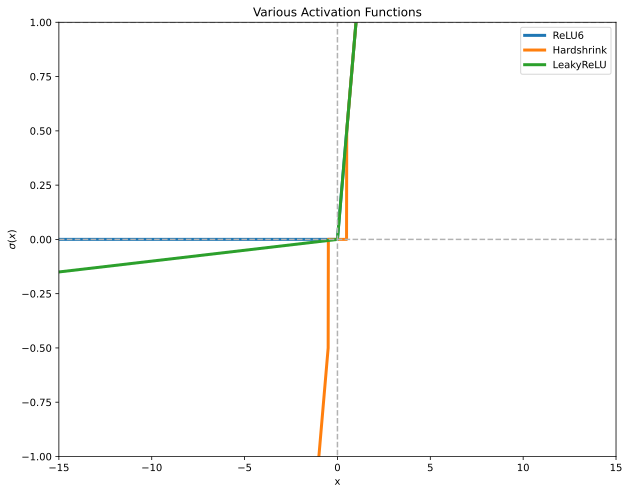

In [38]:
# Zoom in to the y-axis
fig = plt.figure(figsize=(10,8))

for actfun in activation_functions:
    plt.plot(x, NNoutput(actfun)(x), label=actfun, linewidth=3)

# Add reference lines to make it better-looking
dashlinecol = [0.7,0.7,0.7]
plt.plot(x[[0,-1]],[0,0], "--", color=dashlinecol)
# plt.plot(x[[0,-1]],[1,1], "--", color=dashlinecol)
plt.plot([0,0], [-15,15], "--", color=dashlinecol)
plt.legend()
plt.xlabel("x")
plt.ylabel("$\sigma(x)$")
plt.title("Various Activation Functions")
plt.xlim(x[[0,-1]])
plt.ylim([-1,1])
plt.show()

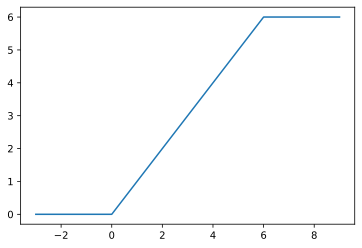

In [39]:
# Let's check ReLU6 in more detail
x = torch.linspace(-3,9,101)
relu6 = torch.nn.ReLU6()

plt.plot(x, relu6(x))
plt.show()

## Differences Between torch and torch.nn

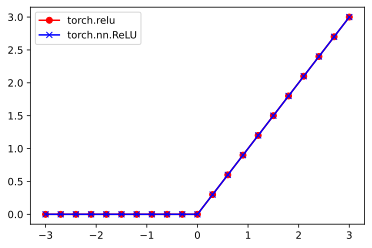

In [40]:
# redefine x again
x = torch.linspace(-3,3, 21)

# in torch
y1 = torch.relu(x)

# in torch.nn
f = torch.nn.ReLU()
y2 = f(x)

# Plot
plt.plot(x, y1, "ro-", label="torch.relu")
plt.plot(x,y2, "bx-", label="torch.nn.ReLU")
plt.legend()
plt.show()

tensor([-2.0000, -1.7895, -1.5789, -1.3684, -1.1579, -0.9474, -0.7368, -0.5263,
        -0.3158, -0.1053,  0.1053,  0.3158,  0.5263,  0.7368,  0.9474,  1.1579,
         1.3684,  1.5789,  1.7895,  2.0000])
tensor([-0.7000, -0.6263, -0.5526, -0.4789, -0.4053, -0.3316, -0.2579, -0.1842,
        -0.1105, -0.0368,  0.0368,  0.1105,  0.1842,  0.2579,  0.3316,  0.4053,
         0.4789,  0.5526,  0.6263,  0.7000])


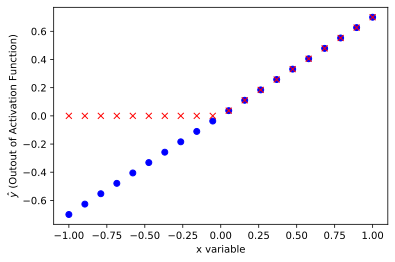

In [41]:
# Explore the difference between linear combintion and nonlinear activation
# Create 2 input vectors
x1 = torch.linspace(-1,1,20)
x2 = 2*x1
print(x2)
print()

# define two weights
w1 = -0.3
w2 = 0.5

# Linear combination
linpart = x1*w1 + x2*w2
print(linpart)

# Non-linear output
y = torch.relu(linpart)

plt.plot(x1, linpart, "bo", label="Linear Input")
plt.plot(x1, y, "rx", label="Non-Linear Output")
plt.ylabel("$\\hat{y}$ (Outout of Activation Function)")
plt.xlabel("x variable")
plt.show()

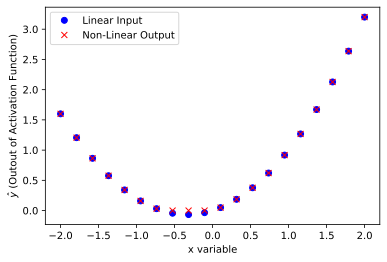

In [42]:
# set x2 to x1**2 and do the same
x1 = torch.linspace(-2,2,20)
x2 = x1**2

# define two weights
w1 = 0.4
w2 = 0.6

# Linear combination
linpart = x1*w1 + x2*w2

# Non-linear output
y = torch.relu(linpart)

plt.plot(x1, linpart, "bo", label="Linear Input")
plt.plot(x1, y, "rx", label="Non-Linear Output")
plt.ylabel("$\\hat{y}$ (Outout of Activation Function)")
plt.xlabel("x variable")
plt.legend()
plt.show()

# Empirical Exploration of Activation Functions

In [43]:
# We will use the Wine dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")

data = data[data["total sulfur dioxide"] < 200]

# No normalization this time
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# Ceate the new boolean for quality
#data["boolQuality"] = 0
#data["boolQuality"][data["quality"] > 5] = 1
tmp = (data["quality"]> 5).astype(int)
data["boolQuality"] = tmp

In [44]:
# Convert pandas dataframe into tensor
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data["boolQuality"].values).float()
# Transfrom the values into matrix
labels = labels[:,None]

In [45]:
# Split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=0.1)

# Convert them to pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Tranlate them into data loader objects
batchsize=32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [46]:
for X,y in test_loader:
    print(X.shape, y.shape)

torch.Size([160, 11]) torch.Size([160, 1])


In [47]:
# Create a class for the model
class ANNwine(nn.Module):
    def __init__(self,actfun):
        super().__init__()

        # Input layer
        self.input = nn.Linear(11,16)

        # Hidden Layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        # Output Layer
        self.output = nn.Linear(32,1)

        # Activation function
        self.actfun = actfun

    # Forward Pass
    def forward(self,x):
        # Get the activation function type
        # Replace torch.relu with torch.<self.actfun>
        actfun = getattr(torch,self.actfun)
        x = actfun(self.input(x))
        x = actfun(self.fc1(x))
        x = actfun(self.fc2(x))

        return self.output(x)

In [48]:
# Test the model
net = ANNwine("sigmoid")
net(torch.randn(10,11)).shape

torch.Size([10, 1])

In [49]:
# Train the Model
numepochs = 1000

def trainTheModel():

    # Define the loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(),lr=0.01)

    # Initialize the losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Turn on the training mode
        winenet.train()

        # Loop over the training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this particual batch
            batchLoss.append(loss.item())
            # Training Accuracy for this batch
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        # End of loop for a single batch

        #Average accuracy of the batches
        trainAcc.append(np.mean(batchAcc))

        # Average losses of the batchs
        losses[epochi] = np.mean(batchLoss)

        # Test Accuracy
        winenet.eval()
        X,y = next(iter(test_loader))
        # Deactivate Autograd
        with torch.no_grad():
            yHat = winenet(X)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
    return trainAcc, testAcc, losses

In [50]:
# Make a list of activation functions to be tested
activation_functions = ["relu", "tanh", "sigmoid"]

trainByAct = np.zeros((numepochs, len(activation_functions)))
testByAct = np.zeros((numepochs, len(activation_functions)))

for ai, actfun in enumerate(activation_functions):
    winenet = ANNwine(actfun)
    trainByAct[:,ai], testByAct[:,ai], losses = trainTheModel()

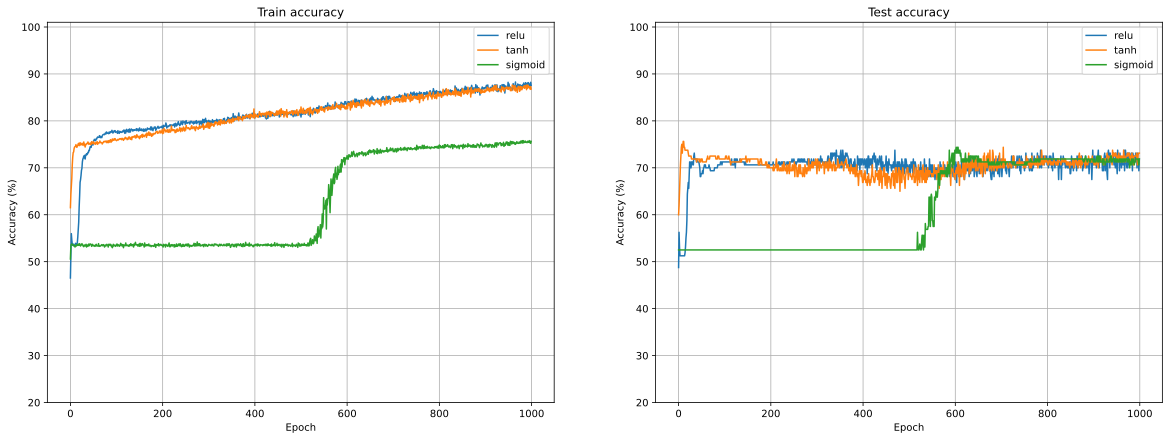

In [51]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_functions)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([20,101])
  ax[i].grid()

plt.show()

# Compare ReLU Variants

In [ ]:
# Create a class for the model
class ANNwine_relu(nn.Module):
    def __init__(self,actfun):
        super().__init__()

        # Input layer
        self.input = nn.Linear(11,16)

        # Hidden Layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        # Output Layer
        self.output = nn.Linear(32,1)

        # Activation function
        self.actfun = actfun

    # Forward Pass
    def forward(self,x):
        # Get the activation function type
        # Replace torch.relu with torch.nn.<self.actfun>
        actfun = getattr(torch.nn,self.actfun)
        x = actfun()(self.input(x))
        x = actfun()(self.fc1(x))
        x = actfun()(self.fc2(x))

        return self.output(x)
# The training function is exactly the same

In [ ]:
# Make a list of activation functions to be tested
activation_functions = ["ReLU", "ReLU6", "LeakyReLU"]

trainByAct = np.zeros((numepochs, len(activation_functions)))
testByAct = np.zeros((numepochs, len(activation_functions)))

for ai, actfun in enumerate(activation_functions):
    winenet = ANNwine_relu(actfun)
    trainByAct[:,ai], testByAct[:,ai], losses = trainTheModel()

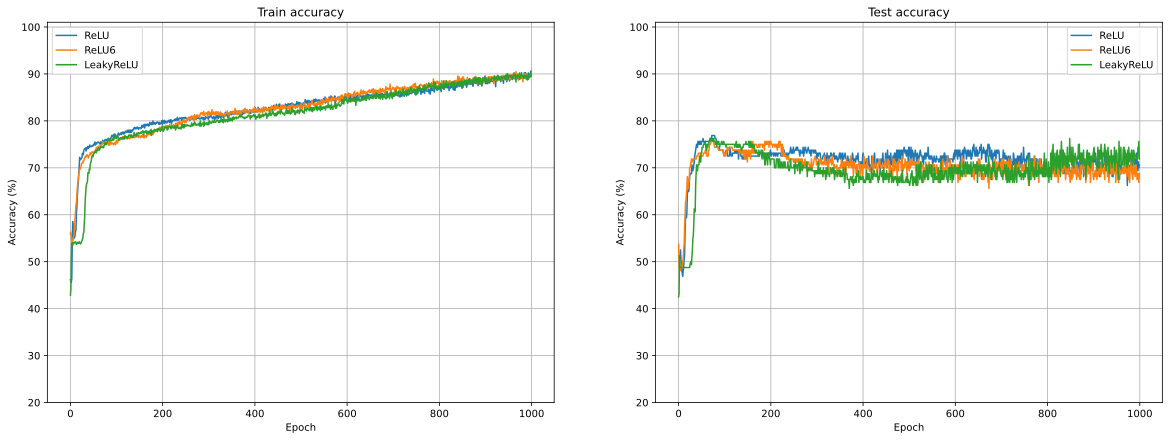

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_functions)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([20,101])
  ax[i].grid()

plt.show()